In [1]:
import gseapy as gp
from tqdm import tqdm
import json
from pathlib import Path
import scanpy as sc
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = Path('/Users/djemec/data/jepa')
clean_path = data_dir / 'cleaned_replogle_k562.h5ad' # original from https://virtualcellmodels.cziscience.com/dataset/k562-essential-perturb-seq
tokenized_dir = data_dir / 'tokenized'
chunk_size = 10000        # How many cells per .npy file
n_pathways = 1024          # Number of pathway "tokens" per cell
QUANTIZATION_MAX = 20.0   # Cap for outlier clamping (log-normalized expression rarely exceeds this)

## Data Load and Explore

The processed dataset is a single, filtered H5ad file. The .X matrix contains the per-cell gene perturbation counts as provided by the authors.  pertrubation counts are based on CRISPR-based screens with single-cell RNA-sequencing readouts. Within this file, there is unstructured data that contains two sets of differentially expressed genes for each condition, one determined using Wilcoxon rank-sum test and the second by t-test. The unstructured data also contains a mapping between control and target cells for each condition as determined by GEM group and library size (UMI count).

In [3]:
adata = sc.read_h5ad(clean_path)

In [4]:
COL_PERTURBATION = 'perturbation'  # The gene being knocked down
COL_CONTROL_LABEL = 'control' # The label string for control cells
COL_BATCH = 'batch' # Batch column (if available) to match controls/treated within same batch

**Cell metadata** (`adata.obs`)

This dataset is a collection of RNA expression counts based on single cell data.  `obs` indexes out the single cell metadata for each cell in the dataset.  Note that when we downloaded the original dataset we filtered the data to only include cells with info on at least 200 genes and info for genes that were detected in at least 3 cells. We can see that this filtering left us with 310385 cells. We then normalized our counts. 

In the cell metadata, 2 columns in particular are important: 
1. `batch` which links control and perturbed cells together
2. `perturbation`which tells us if the cell is a `control` or which gene was knocked out

In [5]:
adata.obs.columns

Index(['batch', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'guide_id',
       'percent_mito', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor',
       'core_adjusted_UMI_count', 'disease', 'cancer', 'cell_line', 'sex',
       'age', 'perturbation', 'organism', 'perturbation_type', 'tissue_type',
       'ncounts', 'ngenes', 'nperts', 'percent_ribo', 'n_genes'],
      dtype='object')

In [6]:
adata.obs.shape

(310385, 25)

In [7]:
adata.obs.head()

,batch,gene,gene_id,transcript,gene_transcript,guide_id,percent_mito,UMI_count,z_gemgroup_UMI,core_scale_factor,...,age,perturbation,organism,perturbation_type,tissue_type,ncounts,ngenes,nperts,percent_ribo,n_genes
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGAAATCCA-27,27,NAF1,ENSG00000145414,P1P2,5449_NAF1_P1P2_ENSG00000145414,NAF1_+_164087918.23-P1P2|NAF1_-_164087674.23-P1P2,0.112083,11438.0,0.013047,0.813253,...,53,NAF1,human,CRISPR,cell_line,11324.0,3332,1,0.225362,3332
AAACCCAAGAACTTCC-31,31,BUB1,ENSG00000169679,P1P2,935_BUB1_P1P2_ENSG00000169679,BUB1_-_111435363.23-P1P2|BUB1_-_111435372.23-P1P2,0.179895,5342.0,-1.522247,0.844107,...,53,BUB1,human,CRISPR,cell_line,5257.0,2192,1,0.129732,2192
AAACCCAAGAAGCCAC-34,34,UBL5,ENSG00000198258,P1P2,9534_UBL5_P1P2_ENSG00000198258,UBL5_-_9938639.23-P1P2|UBL5_+_9938801.23-P1P2,0.105287,17305.0,0.384157,1.091537,...,53,UBL5,human,CRISPR,cell_line,17135.0,4002,1,0.236825,4002
AAACCCAAGAATAGTC-43,43,C9orf16,ENSG00000171159,P1P2,1131_C9orf16_P1P2_ENSG00000171159,C9orf16_+_130922603.23-P1P2|C9orf16_+_13092264...,0.099359,30244.0,3.721912,0.948277,...,53,C9orf16,human,CRISPR,cell_line,29717.0,5358,1,0.246828,5358
AAACCCAAGACAGCGT-28,28,TIMM9,ENSG00000100575,P1P2,8927_TIMM9_P1P2_ENSG00000100575,TIMM9_-_58893843.23-P1P2|TIMM9_-_58893848.23-P1P2,0.137623,8407.0,-0.975371,0.868942,...,53,TIMM9,human,CRISPR,cell_line,8261.0,2944,1,0.183392,2944


**Batch 27**

Let's look at a single batch.  We'll randomly pick 27 and a few common columns out.  Here we can see that we have a non-targetting/control along with 7736 other perturbation.  Each perturbation in this case is CRISPR knockout of a single gene.  In other datasets you might see introduction of a drug so this can become important as we expand the dataset.  Another key piece to keep in the back of the mind right now is that even our control is cancerous (`disease == chronic myeloid leukemia`).  A couple other userful pieces in the cell metadata is ncounts that tells you the total RNA reads for the cell detected and ngenes that tells us the total non-zero genes identified.  These are great filters 

In [8]:
adata.obs[adata.obs.batch == 27][['batch','gene','disease', 'cancer', 'perturbation', 'perturbation_type', 
                                  'tissue_type','ncounts', 'ngenes', 'nperts']]

,batch,gene,disease,cancer,perturbation,perturbation_type,tissue_type,ncounts,ngenes,nperts
cell_barcode,,,,,,,,,,
AAACCCAAGAAATCCA-27,27,NAF1,chronic myeloid leukemia,True,NAF1,CRISPR,cell_line,11324.0,3332,1
AAACCCAAGCGTCTGC-27,27,non-targeting,chronic myeloid leukemia,True,control,CRISPR,cell_line,14483.0,3916,0
AAACCCAAGCTGGTGA-27,27,CDAN1,chronic myeloid leukemia,True,CDAN1,CRISPR,cell_line,12906.0,3288,1
AAACCCACACCAGCCA-27,27,KDM8,chronic myeloid leukemia,True,KDM8,CRISPR,cell_line,12976.0,3950,1
AAACCCAGTACAAGCG-27,27,CBLN1,chronic myeloid leukemia,True,CBLN1,CRISPR,cell_line,17600.0,4361,1
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGGACCTC-27,27,SRBD1,chronic myeloid leukemia,True,SRBD1,CRISPR,cell_line,17689.0,4246,1
TTTGTTGGTTGGACCC-27,27,TIMM23B,chronic myeloid leukemia,True,TIMM23B,CRISPR,cell_line,8720.0,2829,1
TTTGTTGTCACGGGCT-27,27,PPP2R1A,chronic myeloid leukemia,True,PPP2R1A,CRISPR,cell_line,10801.0,3273,1


## 

**Gene metadata** (`adata.var`)

`var` indexes out the gene metadata that we see expressed in this dataset.  This  corresponds with the columns in `adata.X` and gives you more information on the gene for linking to different datasets or for performing filtering.   Recall that we filtered for genes that were found in at least 3 cells so, if we were to do this manually, we'd use the `ncells` column. We can also see this dataset contains a total of 8563 genes

In [9]:
adata.var.shape

(8563, 15)

In [10]:
adata.var.head()

,chr,start,end,class,strand,length,in_matrix,mean,std,cv,fano,ensembl_id,ncounts,ncells,n_cells
gene_name,,,,,,,,,,,,,,,
LINC01409,chr1,778747,810065,gene_version10,+,31318,True,0.137594,0.380048,2.762105,1.049733,ENSG00000237491,42707.0,39082,39082
LINC01128,chr1,825138,868202,gene_version9,+,43064,True,0.256720,0.520162,2.026184,1.053944,ENSG00000228794,79682.0,68732,68732
NOC2L,chr1,944203,959309,gene_version11,-,15106,True,1.975144,1.707837,0.864665,1.476706,ENSG00000188976,613055.0,248759,248759
KLHL17,chr1,960584,965719,gene_version14,+,5135,True,0.119593,0.353702,2.957540,1.046089,ENSG00000187961,37120.0,34277,34277
HES4,chr1,998962,1000172,gene_version10,-,1210,True,0.249577,0.561933,2.251540,1.265214,ENSG00000188290,77465.0,62316,62316


**Extract Gene Names**   

Since we'll need the genes later one for analysis, i'll go ahead and store the gene names into a variable so that we'll have it easy to call later. 

In [11]:
genes = adata.var_names.tolist()
len(genes)

8563

**Cell X Gene Matrix** (`adata.X`)

`adata.X` is the count matrix (cells × genes) that stores our expression values. We can see that this has as a result 310385 rows (the cells) and 8563 columns (the genes expressed).  The matrix will fill in 0 for the rows not expressed. During preprocessing, we did 2 normalizations on the count frequency: 
1. `sc.pp.normalize_total(adata, target_sum=1e4)`: We rescaled the rows (cells) so that every cell has the same total count (10,000), correcting for technical differences in sequencing depth so cells are directly comparable.
2. `sc.pp.log1p(adata)`: We took the natural logarithm of every value (ln(X+1)), which compressed the range of the data so that a few highly expressed genes don't dominate the analysis (variance stabilization).
Because of this, we can see our values overall are a lot closer together.  

In [12]:
adata.X.shape

(310385, 8563)

In [13]:
adata.X[:10]

array([[0.        , 0.6329088 , 0.6329088 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.065478  , 1.065478  ,
        0.        ],
       [0.        , 0.45970124, 0.45970124, ..., 0.45970124, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 1.616192  , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.0913761 , ..., 0.50649023, 0.        ,
        0.        ],
       [0.        , 0.40031558, 0.40031558, ..., 0.        , 0.        ,
        0.40031558]], shape=(10, 8563), dtype=float32)

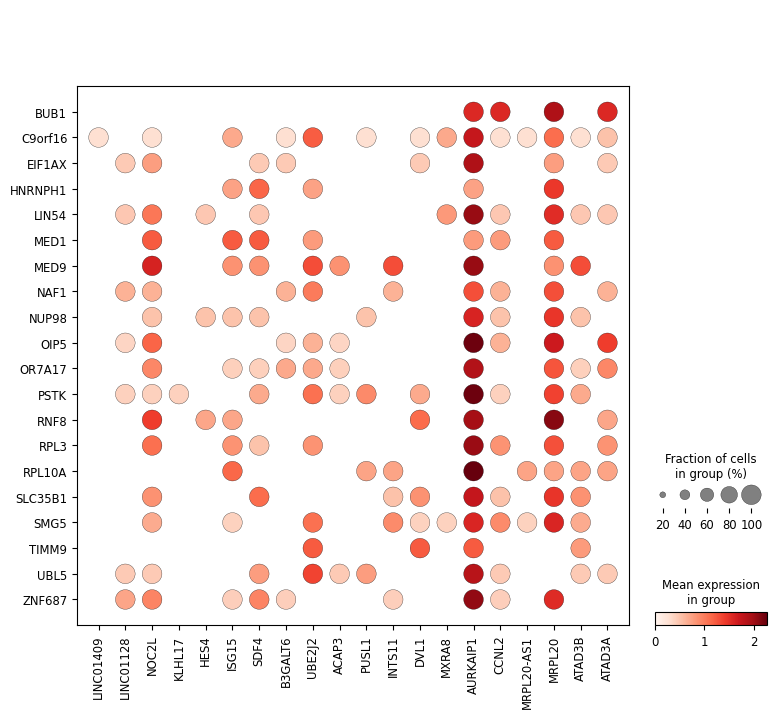

In [14]:
genes_of_interest = adata.var_names[:20] 

# Group by the column in adata.obs (e.g., 'condition' or 'guide_id')
#sc.pl.heatmap(adata, genes_of_interest, groupby='guide_id', cmap='viridis')
sc.pl.dotplot(adata[:20], genes_of_interest, groupby='perturbation')

## Reactome Map
For our world model we want to learn about pathways, not specific genes. As we increase data set variety and perturbation type, focusing on a model that understands pathway impact will allow us to better model different perturbations and understand their impact even if we aren't fully sure of the underlying mechanisms. Over time, this will also allow us to derive new theories on mechanism of action. 

To get started we'll use the [rummaGEO](https://rummageo.com/about) dataset mainly because it has the best overlap with the genes we have in our dataset.  This will give us a detailed, close to up to date, starting point to work backwards from.  

The dataset we're using is a fairly simple dictionary: it uses the pathway name as the key and then has the gene abbreviation in the items. 


Other datasets
* RummaGEO_GenePerturbations_2025 - 7961
* PerturbAtlas - 7741
* DSigDB - 7540

In [15]:
gs_res = gp.get_library(name='RummaGEO_GenePerturbations_2025', organism='Human')

In [16]:
gs_res['GSE103567 EZH2 Inhibition 5 V 2 Human up']

['UNC13C',
 'STARD5',
 'GLYCTK',
 'MED9',
 'RFX3',
 'WDR76',
 'GANC',
 'GALNS',
 'KIAA1217',
 'CAPN12',
 'CPEB2',
 'NECAP2',
 'ZC2HC1B',
 'POLR3F',
 'CDIN1',
 'RNF220',
 'CDK16',
 'CYBC1',
 'CLDND2',
 'GPATCH3',
 'ARAF',
 'DPYSL2',
 'PRPSAP1',
 'PSMD4',
 'TMEM69',
 'TYW1',
 'VPS16',
 'ZSCAN18',
 'NXNL2',
 'RALY',
 'ARL14EP',
 'TOE1',
 'ST14',
 'ZNF10',
 'BAZ1B',
 'FN3KRP',
 'ELL3',
 'MASTL',
 'H1-4',
 'SUPV3L1',
 'BACE2',
 'H1-6',
 'MLLT10',
 'PSME2',
 'ITPA',
 'PRKCQ',
 'MCPH1',
 'ATF5',
 'ZNF256',
 'CDC42SE1',
 'RRP8',
 'ZNF133',
 'ZNF253',
 'HACD1',
 'CDCA5',
 'DIS3L',
 'NGLY1',
 'BAZ2A',
 'PDGFB',
 'BAZ2B',
 'ELK1',
 'FARS2',
 'H2AC19',
 'ZNF28',
 'BLOC1S5',
 'IL4I1',
 'MRPL20',
 'EDRF1',
 'FAM110A',
 'NTMT1',
 'PLAC8',
 'SPIB',
 'PIP5K1A',
 'CDK5RAP1',
 'MMUT',
 'PSMF1',
 'MYBL2',
 'PUSL1',
 'ATG5',
 'NKX3-2',
 'XYLB',
 'ZNF487',
 'CTC1',
 'ZNF485',
 'LYPLA2',
 'EIPR1',
 'NSUN5',
 'NSUN4',
 'TMCO4',
 'LRPPRC',
 'APBB1IP',
 'SPOUT1',
 'NCOR1',
 'ADI1',
 'HEATR5B',
 'PAX9',
 'AGO2',

Some regulatory pathways are quite sizeable and others very tiny.  Longer term we'd want to include all these pathways, but for now, we want to try to keep long-tails out of our dataset.  If we look at the distribution of genes in each network we see a long top tail.  We'll go ahead and clip the top off to prevent this long tail.  We'll arbitrarily pick all the pathways with more than 75 and less than 500 genes given that leads to covering most of the genes that we have expression data for without going too wide on our pathway counts. 

(array([1050.,  444.,  466.,  433.,  472.,  437.,  404.,  319.,  224.,
          63.]),
 array([   5. ,  197.5,  390. ,  582.5,  775. ,  967.5, 1160. , 1352.5,
        1545. , 1737.5, 1930. ]),
 <BarContainer object of 10 artists>)

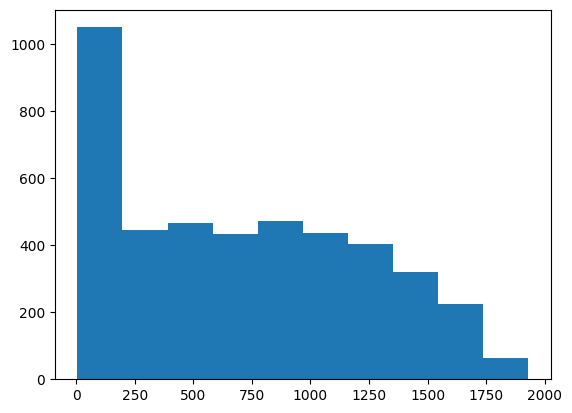

In [17]:
plt.hist([len(v) for k,v in gs_res.items()])

(array([145., 108., 117.,  95., 103.,  87., 108., 107.,  96., 108.]),
 array([ 75. , 117.5, 160. , 202.5, 245. , 287.5, 330. , 372.5, 415. ,
        457.5, 500. ]),
 <BarContainer object of 10 artists>)

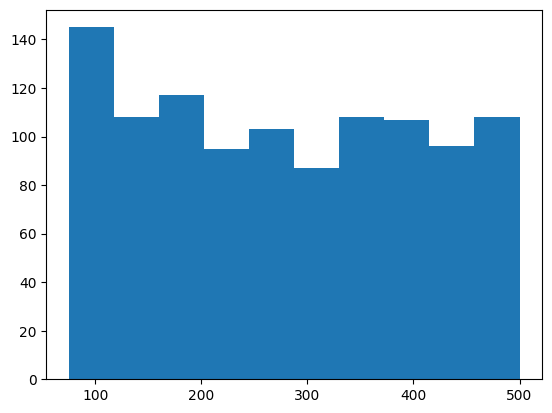

In [18]:
plt.hist([len(v) for k,v in gs_res.items() if 75 <= len(v) <= 500])

In [19]:
valid_pathways = {k: v for k, v in gs_res.items() if 75 <= len(v) <= 500}
len(list(valid_pathways.keys())), n_pathways

(1074, 1024)

We can see that even with cutting off the top tail we're still above our target, so we'll arbitrarily just select the first set up to our target number. 

In [20]:
selected_keys = list(valid_pathways.keys())[:n_pathways]
pathway_names = selected_keys
len(pathway_names)

1024

**Compare pathways and expression data for overlap**

We'll now see how many of our total genes we have in our reactome dataset. Recall that we started with 8563

In [21]:
reactome_genes = set(list(sum([v for k, v in valid_pathways.items() if k in selected_keys],[])))
len(reactome_genes)

18349

In [22]:
# genes we have expression for and reactome information for 
f'originally {len(set(genes))} but after {len(set(genes)) - len(set(genes) - reactome_genes)}'

'originally 8563 but after 7957'

## Mask

Normalized Multi-Hot Encoding.

A row for each pathway, and then put a "1" for each gene (column), and after you're done with that pathway divide it by the total to normalize the weight

In [24]:
mask = np.zeros((len(genes), len(selected_keys)), dtype=np.float32)
gene_to_idx = {gene: i for i, gene in enumerate(genes)}

In [32]:
p_idx, p_name = 1, selected_keys[0]
p_idx, p_name

(1, 'GSE100148 EZH2 Inhibition 10 V 5 Human up')

In [58]:
genes_in_pathway = valid_pathways[p_name]
hit_count = 0

In [59]:
for gene in genes_in_pathway:
    if gene in gene_to_idx:
        print(f'YES {gene} found in counts for {p_idx}')
        mask[gene_to_idx[gene], p_idx] = 1.0
        hit_count += 1
        
if hit_count > 0:
    print(hit_count)
    mask[:, p_idx] /= hit_count
        

YES POLR2J3 found in counts for 1
YES IFRD2 found in counts for 1
YES SLC50A1 found in counts for 1
YES GATAD2B found in counts for 1
YES RUFY1 found in counts for 1
YES FDX2 found in counts for 1
YES TARS2 found in counts for 1
YES SMARCAL1 found in counts for 1
YES SF3B4 found in counts for 1
YES ZNF274 found in counts for 1
YES CPNE8 found in counts for 1
YES MAML1 found in counts for 1
YES GPATCH4 found in counts for 1
YES DCAF8 found in counts for 1
YES MYL12B found in counts for 1
YES KRTCAP2 found in counts for 1
YES ZNF827 found in counts for 1
YES PSMD4 found in counts for 1
YES STAT6 found in counts for 1
YES COG8 found in counts for 1
YES MAGEC1 found in counts for 1
YES NR2F2 found in counts for 1
YES PTK7 found in counts for 1
YES PRRC2C found in counts for 1
YES MOV10 found in counts for 1
YES RPS27 found in counts for 1
YES VANGL2 found in counts for 1
YES MYL12A found in counts for 1
YES UCK2 found in counts for 1
YES PRKAR1B found in counts for 1
YES JTB found in count

In [60]:
mask[gene_to_idx['POLR2J3'],1]

np.float32(0.005952381)

In [ ]:
for p_idx, p_name in enumerate(selected_keys):
    genes_in_pathway = valid_pathways[p_name]
    hit_count = 0
    for gene in genes_in_pathway:
        if gene in gene_to_idx:
            mask[gene_to_idx[gene], p_idx] = 1.0
            hit_count += 1
    
    # Normalize
    if hit_count > 0:
        mask[:, p_idx] /= hit_count
        
gene_mask = mask